In [1]:
import os
import torch
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import models.ae as ae

In [2]:
weights_dir = 'weights/'
weights_path = os.path.join(weights_dir, 'ae_best.pth.tar')

data_dir = 'images/'
image_path = os.path.join(data_dir, 'data_0165.png')
label_path = os.path.join(data_dir, 'data_0165_label.png')
query_patch_path = os.path.join(data_dir, 'data_0165_mito_crop.png')

In [3]:
image = imageio.imread(image_path)
label = imageio.imread(label_path)
query_patch = imageio.imread(query_patch_path)

In [4]:
model = ae.AE(32)
model.load_state_dict(torch.load(weights_path)['state_dict'])
model.eval()
# model = model.cuda()

AE(
  (zeropad1): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (zeropad2): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (zeropad3): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_enc): Linear(in_features=2048, out_features=32, bias=True)
  (fc_dec): Linear(in_features=32, out_features=2048, bias=True)
  (t_conv1): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
  (loss): BCELoss()
)

In [5]:
def calculate_ssd(img1, img2):
    """Computing the sum of squared differences (SSD) between two images."""
    if img1.shape != img2.shape:
        raise Exception("Images don't have the same shape: ", img1.shape, "and", img2.shape)
    return np.sum((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32))**2)

In [6]:
def compute_descriptor(descr, patch):
    variational = False  # isinstance(descr, vae.BetaVAE) or isinstance(descr, vae_ir.BetaVAE)
    patch = np.array(patch)
    patch = patch / 255.0
    patch = np.expand_dims(np.expand_dims(patch, axis=0), axis=0)
    patch = torch.from_numpy(patch).float()
    if variational:
        patch_encoding, _, _ = descr.encode(patch)
    else:
        patch_encoding = descr.encode(patch)
    patch_encoding = patch_encoding.detach().numpy()
    patch_encoding = patch_encoding.reshape(patch_encoding.shape[0], np.product(patch_encoding.shape[1:]))
    return patch_encoding[0]

In [59]:
patch_size = 65
compare_stride = 8
eps = 0.0001
nr_similar_patches = 16

In [10]:
image_height = image.shape[0]
image_width = image.shape[1]

query_patch_descr = compute_descriptor(model, query_patch)

counter_compare_patches = 0

patches_diffs = [1000000000]
patches_x_coords = [-1]
patches_y_coords = [-1]
patches_positions = [-1]


for y_compare in range(0, image_width - patch_size + 1, compare_stride):
    for x_compare in range(0, image_height - patch_size + 1, compare_stride):

        compare_patch = image[x_compare: x_compare + patch_size, y_compare: y_compare + patch_size]

        compare_patch_descr = compute_descriptor(model, compare_patch)

        diff = calculate_ssd(query_patch_descr, compare_patch_descr)

        if diff < eps:  # or (x_compare == x_query and y_compare == y_query):
            counter_compare_patches += 1
            continue

        # sorting
        for i in range(len(patches_diffs)):
            if diff < patches_diffs[i]:
                patches_diffs.insert(i, diff)
                patches_x_coords.insert(i, x_compare)
                patches_y_coords.insert(i, y_compare)
                patches_positions.insert(i, counter_compare_patches)
                break

        counter_compare_patches += 1



In [60]:
results_patches_diffs = patches_diffs[:nr_similar_patches]
results_patches_x_coords = patches_x_coords[:nr_similar_patches]
results_patches_y_coords = patches_y_coords[:nr_similar_patches]
results_patches_positions = patches_positions[:nr_similar_patches]

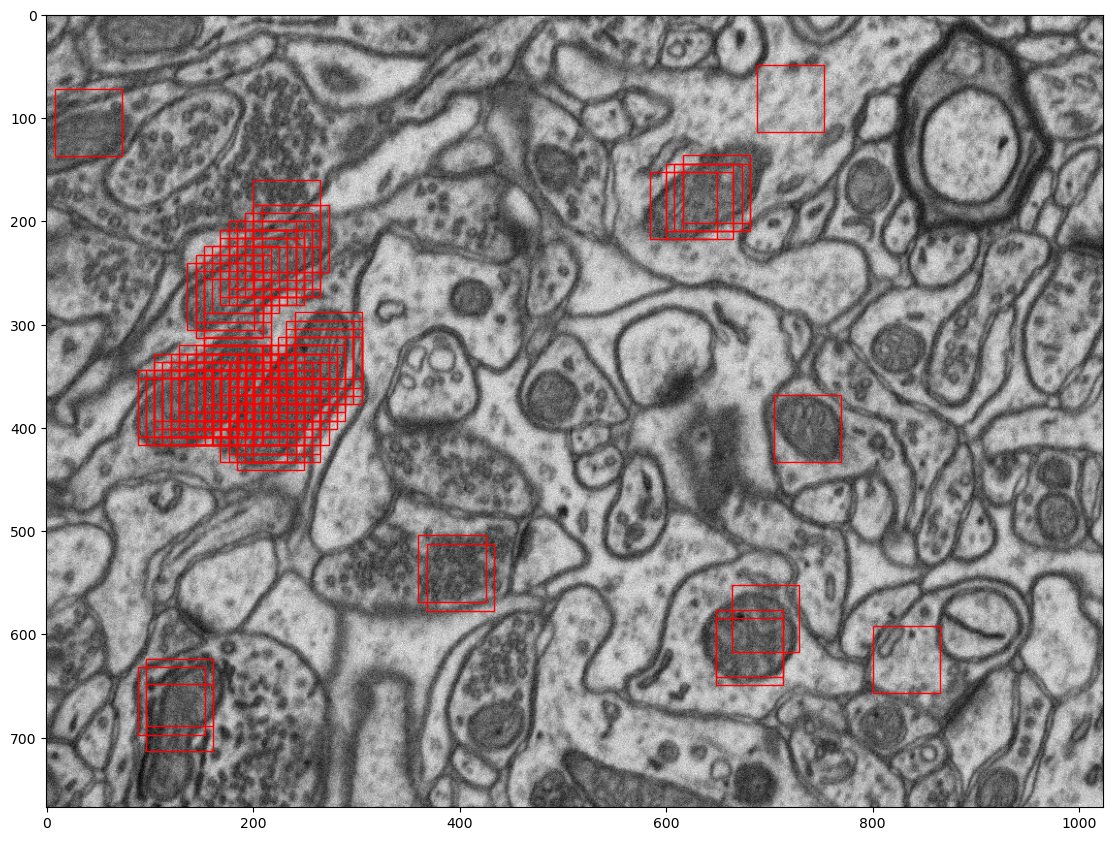

In [61]:
fig, ax = plt.subplots(1)
fig.set_size_inches(18.5, 10.5)
fig.set_dpi(100)
ax.imshow(image, cmap='gray')

for i, patch_match in enumerate(results_patches_positions):
    rect = patches.Rectangle((results_patches_y_coords[i], results_patches_x_coords[i]),
                             65, 65, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# fig.tight_layout()
plt.savefig('images/results/data_0165_patchmatch' + str(nr_similar_patches).zfill(3) + '.png', bbox_inches='tight')
plt.show()

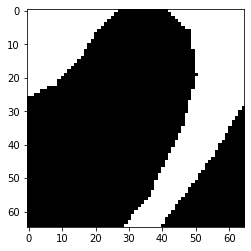

0.6809467455621302



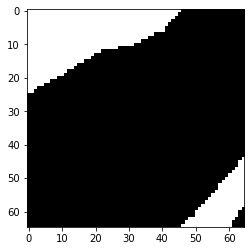

0.8087573964497041



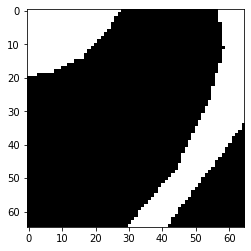

0.7538461538461538



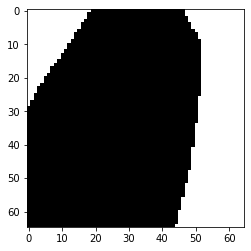

0.6946745562130178



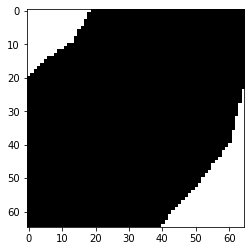

0.8504142011834319



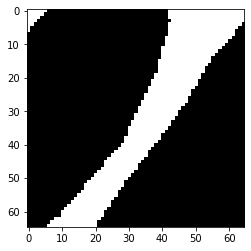

0.7784615384615384



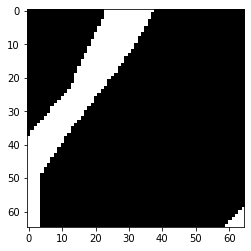

0.8504142011834319



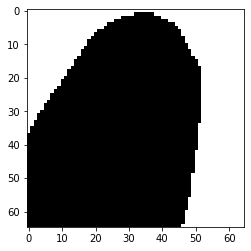

0.6390532544378699



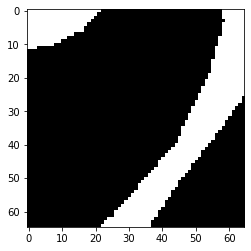

0.7910059171597633



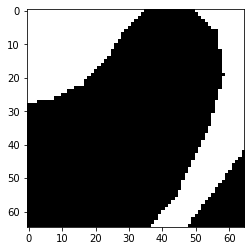

0.6942011834319527



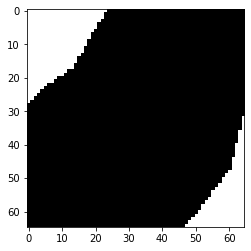

0.8513609467455622



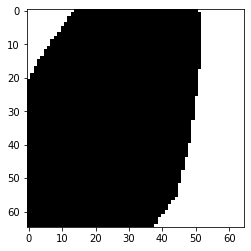

0.7107692307692308



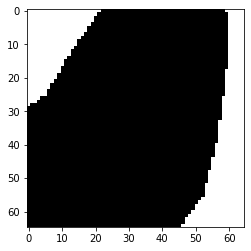

0.7841420118343195



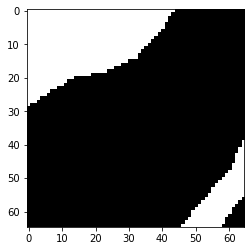

0.7720710059171597



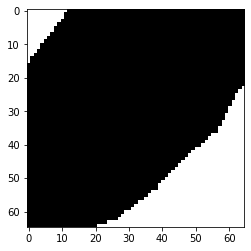

0.7938461538461539



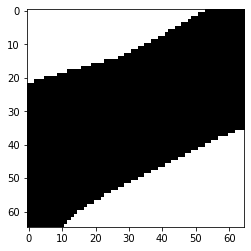

0.6231952662721894



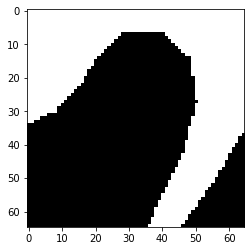

0.5810650887573965



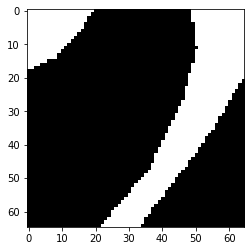

0.7405917159763313



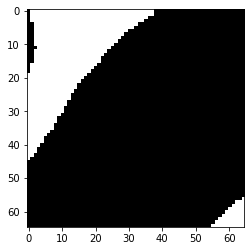

0.8115976331360947



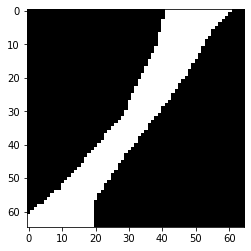

0.7895857988165681



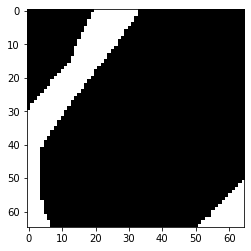

0.8466272189349112



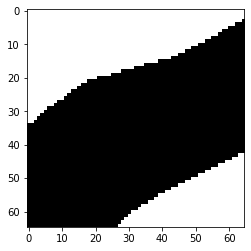

0.616094674556213



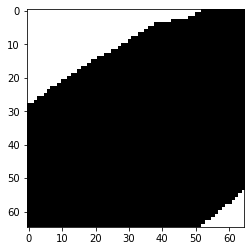

0.8272189349112427



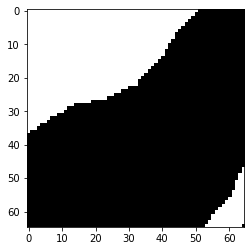

0.7036686390532544



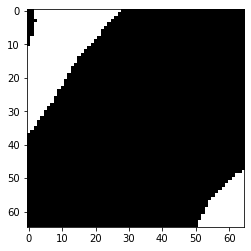

0.8492307692307692



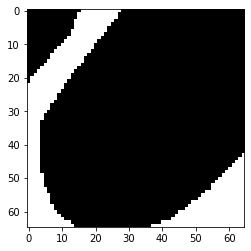

0.8130177514792899



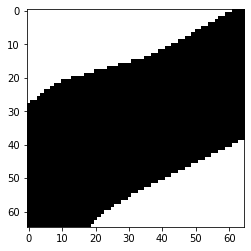

0.6279289940828402



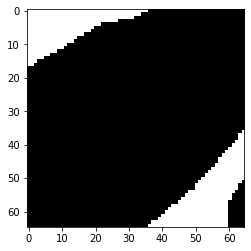

0.8520710059171598



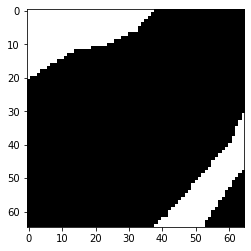

0.8253254437869822



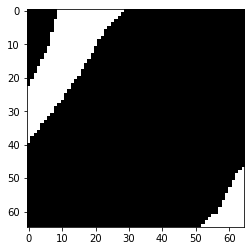

0.8641420118343195



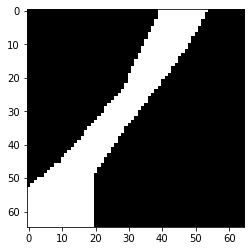

0.7846153846153846



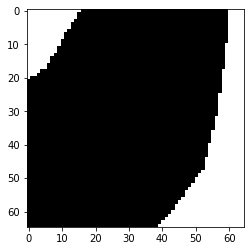

0.7874556213017752



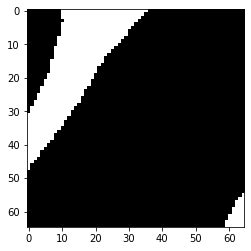

0.8395266272189349



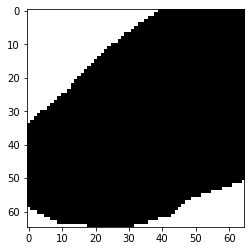

0.7794082840236687



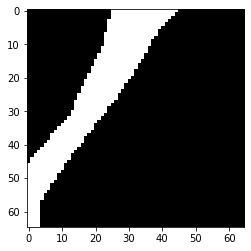

0.8300591715976331



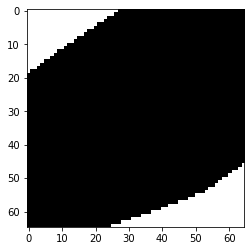

0.8594082840236686



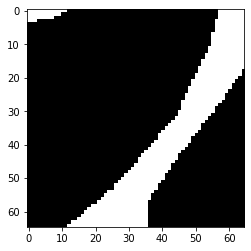

0.8018934911242603



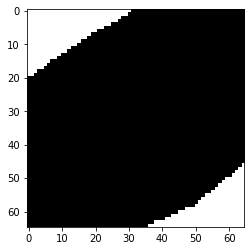

0.866508875739645



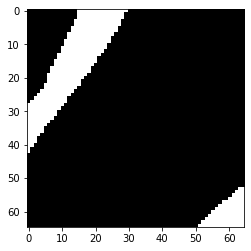

0.8743195266272189



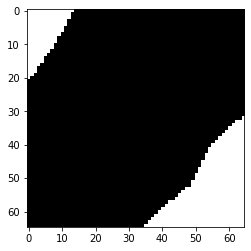

0.8411834319526628



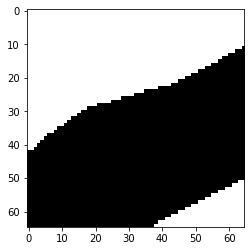

0.557396449704142



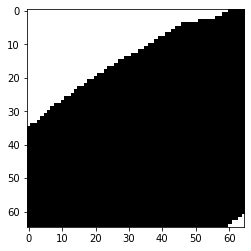

0.7810650887573964



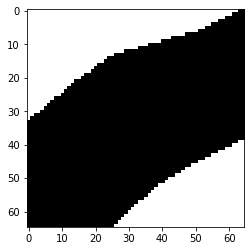

0.6480473372781065



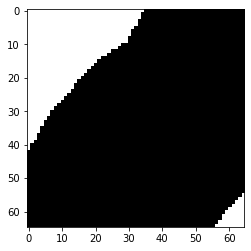

0.818698224852071



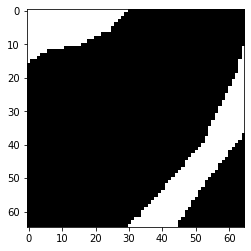

0.8217751479289941



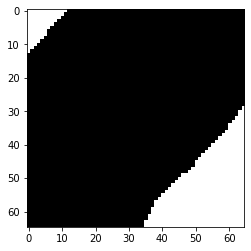

0.8421301775147929



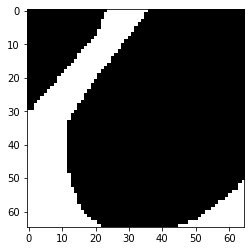

0.7753846153846153



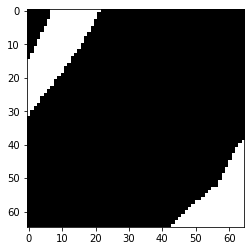

0.8620118343195267



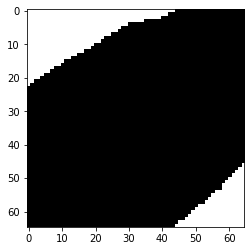

0.8471005917159763



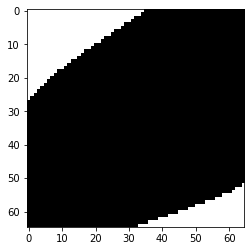

0.8459171597633136



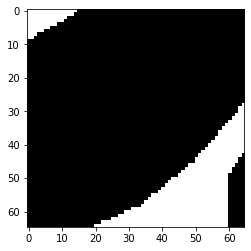

0.8402366863905325



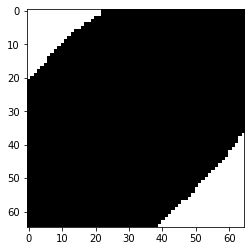

0.8622485207100592



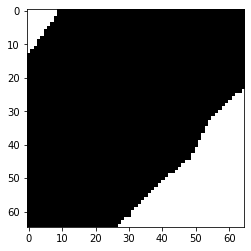

0.7988165680473372



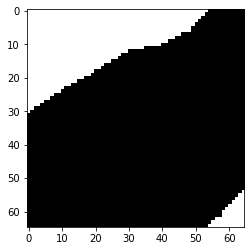

0.7829585798816568



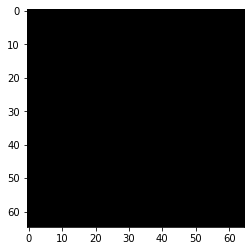

0.0



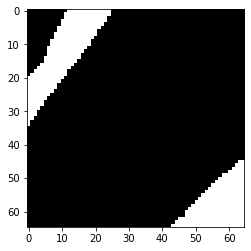

0.8662721893491124



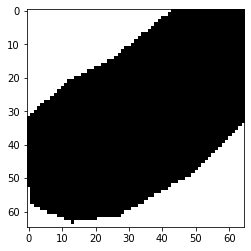

0.6733727810650888



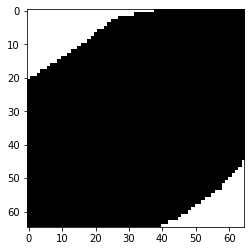

0.8679289940828402



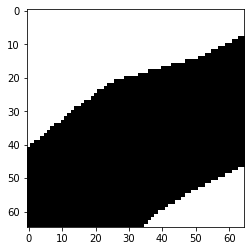

0.592189349112426



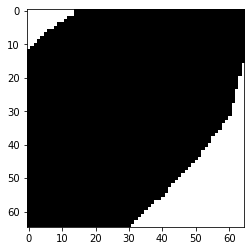

0.8246153846153846



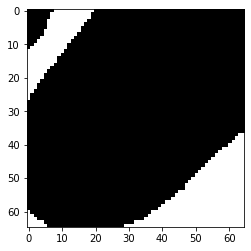

0.8324260355029586



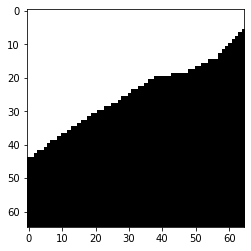

0.6118343195266273



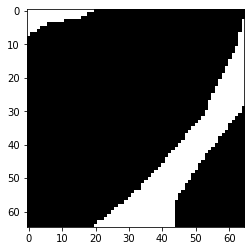

0.834792899408284



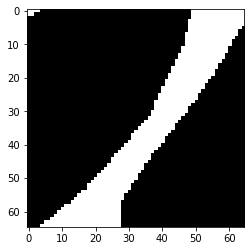

0.7886390532544378



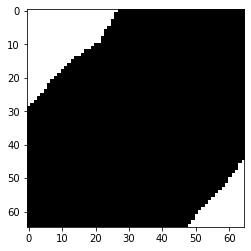

0.8577514792899408



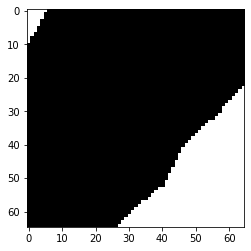

0.7997633136094675



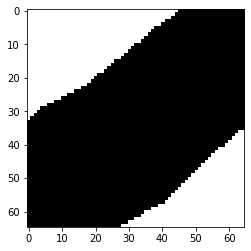

0.6906508875739645



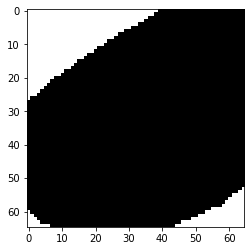

0.8466272189349112



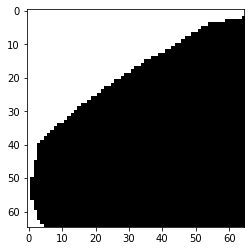

0.6982248520710059



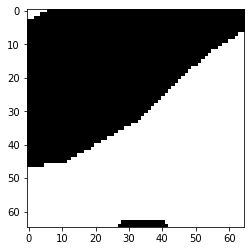

0.4717159763313609



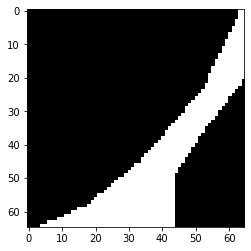

0.7940828402366864



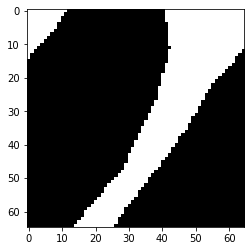

0.7413017751479289



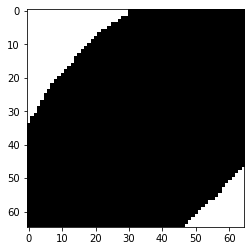

0.853491124260355



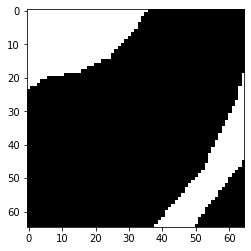

0.7836686390532545



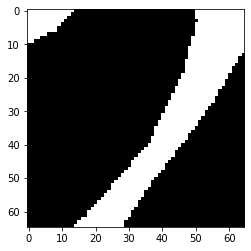

0.7777514792899408



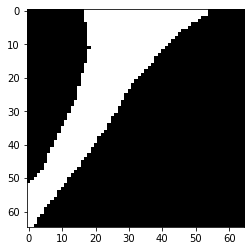

0.7611834319526627



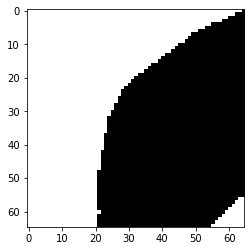

0.5140828402366864



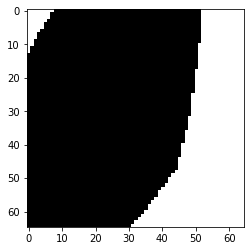

0.6989349112426035



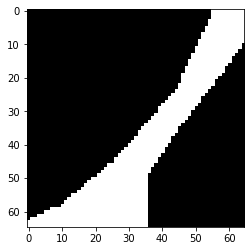

0.7668639053254438



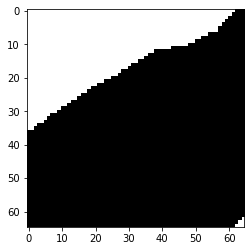

0.7327810650887574



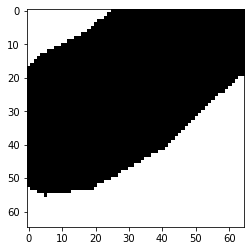

0.6089940828402367



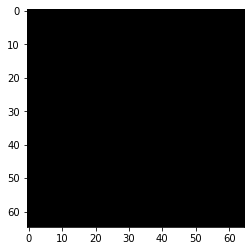

0.0



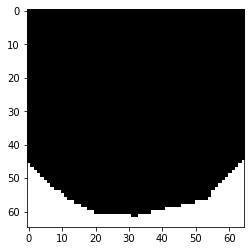

0.8681656804733728



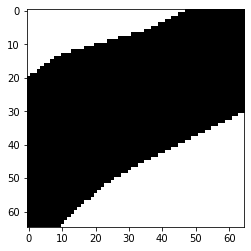

0.6340828402366864



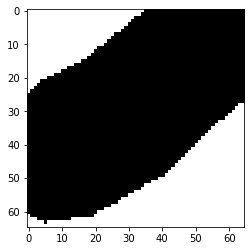

0.6740828402366864



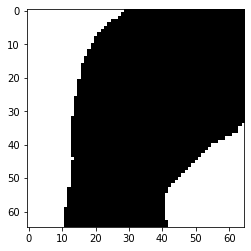

0.6418934911242603



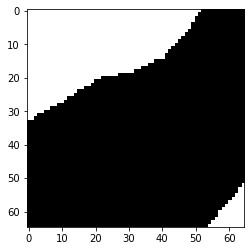

0.7403550295857988



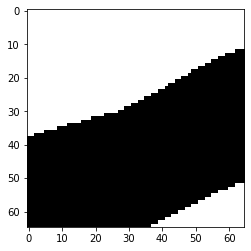

0.5479289940828402



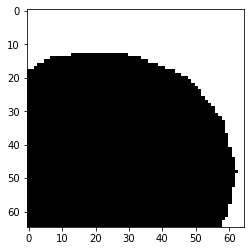

0.6790532544378698



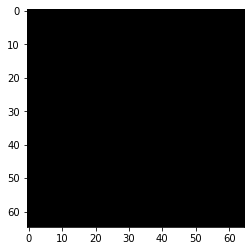

0.0



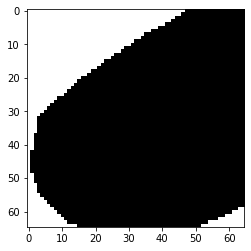

0.7779881656804734



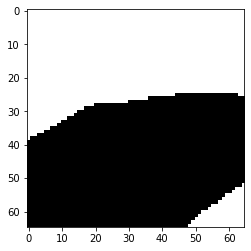

0.5325443786982249



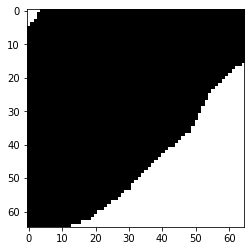

0.7273372781065088



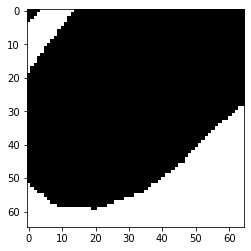

0.7391715976331361



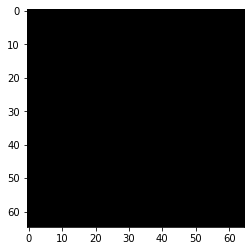

0.0



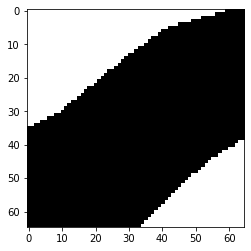

0.6691124260355029



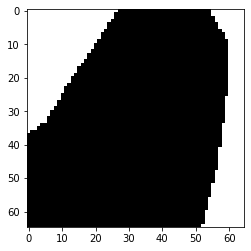

0.7528994082840237



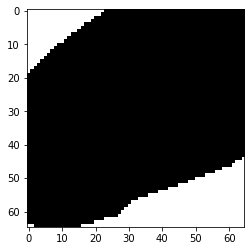

0.8274556213017752



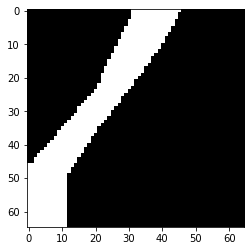

0.8130177514792899



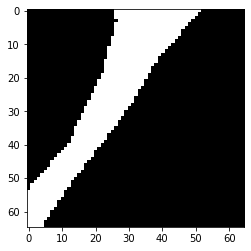

0.7950295857988166



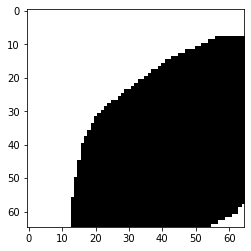

0.543905325443787



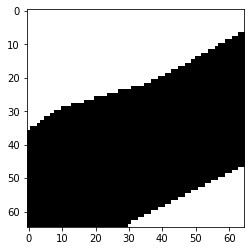

0.5848520710059172



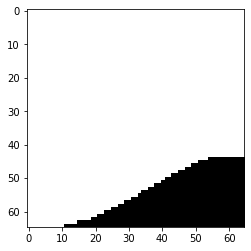

0.1545562130177515



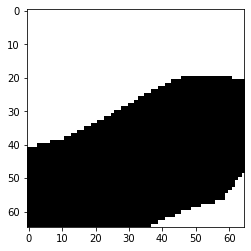

0.5185798816568047



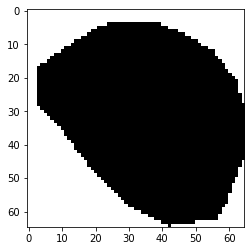

0.6418934911242603



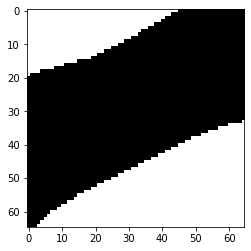

0.6044970414201184



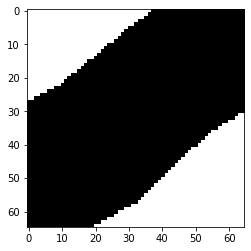

0.6866272189349112



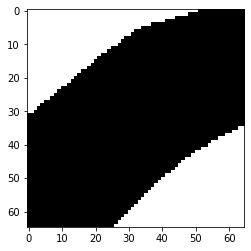

0.6785798816568047



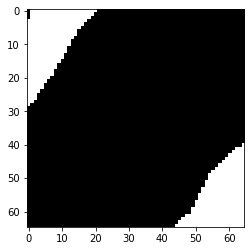

0.858698224852071



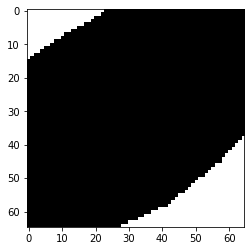

0.856094674556213



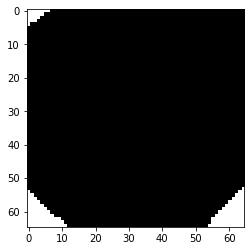

0.9609467455621302



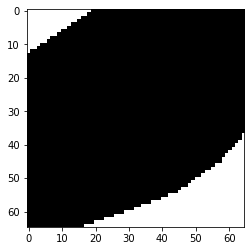

0.8461538461538461



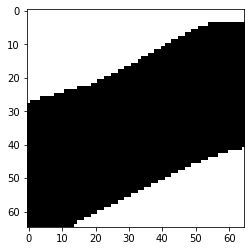

0.605207100591716



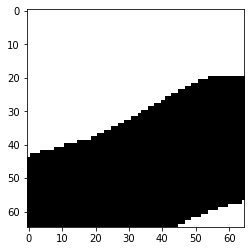

0.49893491124260353



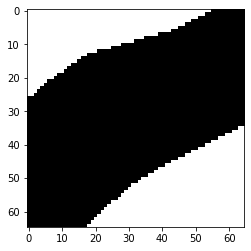

0.6511242603550296



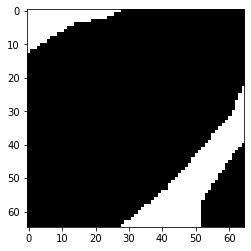

0.853491124260355



In [62]:
maximum_correct_pixels = patch_size**2
results_patches_correct_pixels = []

for i, patch_match in enumerate(results_patches_positions):
    patch_match_label = label[results_patches_x_coords[i]: results_patches_x_coords[i] + patch_size,
                              results_patches_y_coords[i]: results_patches_y_coords[i] + patch_size]
    plt.imshow(patch_match_label, cmap='gray')
    plt.show()
    correct_pixels = np.sum(patch_match_label == 1)
    print(correct_pixels/maximum_correct_pixels)
    print()
    results_patches_correct_pixels.append(correct_pixels/maximum_correct_pixels)
    

In [63]:
results_patches_correct_pixels

[0.6809467455621302,
 0.8087573964497041,
 0.7538461538461538,
 0.6946745562130178,
 0.8504142011834319,
 0.7784615384615384,
 0.8504142011834319,
 0.6390532544378699,
 0.7910059171597633,
 0.6942011834319527,
 0.8513609467455622,
 0.7107692307692308,
 0.7841420118343195,
 0.7720710059171597,
 0.7938461538461539,
 0.6231952662721894,
 0.5810650887573965,
 0.7405917159763313,
 0.8115976331360947,
 0.7895857988165681,
 0.8466272189349112,
 0.616094674556213,
 0.8272189349112427,
 0.7036686390532544,
 0.8492307692307692,
 0.8130177514792899,
 0.6279289940828402,
 0.8520710059171598,
 0.8253254437869822,
 0.8641420118343195,
 0.7846153846153846,
 0.7874556213017752,
 0.8395266272189349,
 0.7794082840236687,
 0.8300591715976331,
 0.8594082840236686,
 0.8018934911242603,
 0.866508875739645,
 0.8743195266272189,
 0.8411834319526628,
 0.557396449704142,
 0.7810650887573964,
 0.6480473372781065,
 0.818698224852071,
 0.8217751479289941,
 0.8421301775147929,
 0.7753846153846153,
 0.86201183431952

In [65]:
np.array(results_patches_correct_pixels).mean()

0.7192042440318303

In [ ]:
maximum_correct_pixels = patch_size**2

for nr_sim_patches_iter in range(20):
    nr_similar_patches = nr_sim_patches_iter * 10 + 6
    print(nr_similar_patches)
    results_patches_diffs = patches_diffs[:nr_similar_patches]
    results_patches_x_coords = patches_x_coords[:nr_similar_patches]
    results_patches_y_coords = patches_y_coords[:nr_similar_patches]
    results_patches_positions = patches_positions[:nr_similar_patches]
    
    fig, ax = plt.subplots(1)
    fig.set_size_inches(18.5, 10.5)
    fig.set_dpi(100)
    ax.imshow(image, cmap='gray')

    for i, patch_match in enumerate(results_patches_positions):
        rect = patches.Rectangle((results_patches_y_coords[i], results_patches_x_coords[i]),
                                 65, 65, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)


    results_patches_correct_pixels = []
    failed_count = 0

    for i, patch_match in enumerate(results_patches_positions):
        patch_match_label = label[results_patches_x_coords[i]: results_patches_x_coords[i] + patch_size,
                                  results_patches_y_coords[i]: results_patches_y_coords[i] + patch_size]
        correct_pixels = np.sum(patch_match_label == 1)
        results_patches_correct_pixels.append(correct_pixels/maximum_correct_pixels)
        if correct_pixels == 0:
            failed_count += 1
    
    mean_correct_pixels = np.array(results_patches_correct_pixels).mean()
    
    file_name = 'data_0165_patchmatch' + str(nr_similar_patches).zfill(3) + '_correctpixels' + "{:.2f}".format(mean_correct_pixels*100) + '_failed' + str(failed_count) + '.png'
    plt.savefig(os.path.join('images/results', file_name), bbox_inches='tight')
    plt.show()
    print(mean_correct_pixels * 100)
    print('failed:', failed_count)
    
    print('\n\n')